In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys, os
sys.path.append(os.path.abspath("../../"))
from pipeoptz import Pipeline, Node, PipelineOptimizer, FloatParameter, IntParameter, mse_loss

In [2]:
def gaussian_blur(image, k, sigma):
    # The kernel size need to be an odd  integer
    k = int(k)*2+1
    return cv2.GaussianBlur(image, (k, k), sigmaX=sigma)

def threshold(image, threshold_value):
    im = image.copy()
    im[cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)[1] == 0] = 0
    return im

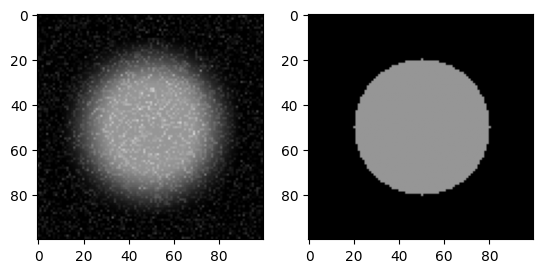

In [3]:
def generate_data():
    # Input image : a blured & noised circle
    X = np.zeros((100, 100), dtype=np.uint8)
    cv2.circle(X, (50, 50), 30, 150, -1)
    y = np.zeros((100, 100), dtype=np.uint8)
    cv2.circle(y, (50, 50), 30, 150, -1)

    X = cv2.GaussianBlur(X, (21, 21), 10)
    noise = np.zeros(X.shape, np.uint8)
    cv2.randn(noise, 0, 20)
    X = cv2.add(X, noise)

    return X, y

X, y = generate_data()
plt.subplot(121)
plt.imshow(X, cmap="gray", vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(y, cmap="gray", vmin=0, vmax=255)

In [4]:
length = 4
X = []
y = []
for _ in range(length):
    Xi, yi = generate_data()
    X.append({"image":Xi})
    y.append(yi)

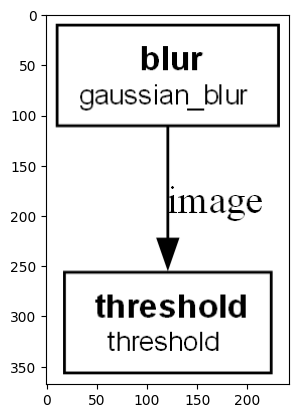

In [5]:
pipeline = Pipeline(name="simple_im_pipeline_opz")
pipeline.add_node(Node(id="blur", func=gaussian_blur, fixed_params={'k': 5, 'sigma': 1.0}), predecessors={'image': 'run_params:image'})
pipeline.add_node(Node(id="threshold", func=threshold, fixed_params={'threshold_value': 127}), predecessors={'image': 'blur'})
pipeline.to_dot("simple_im_pipeline_opz.dot", generate_png=True)
plt.imshow(Image.open("simple_im_pipeline_opz.png"))

In [6]:
optimizer = PipelineOptimizer(
        pipeline=pipeline,
        loss_function=mse_loss,
        max_time_pipeline=0.10
    )

optimizer.add_param(FloatParameter(node_id='blur', param_name='sigma', min_value=0.1, max_value=20.0))
optimizer.add_param(IntParameter(node_id='blur', param_name='k', min_value=1, max_value=10))
optimizer.add_param(IntParameter(node_id='threshold', param_name='threshold_value', min_value=1, max_value=254))

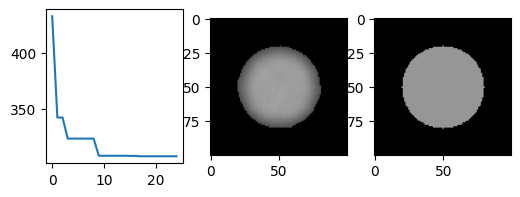

In [7]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="ACO", 
        iterations=25,
        ants=10,
        verbose=True
)

i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

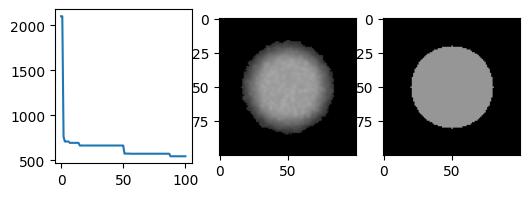

In [8]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="SA", 
        iterations=100,
        verbose=True
)

i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

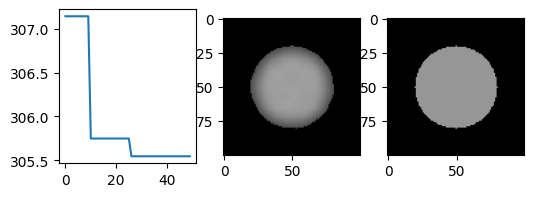

In [9]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="PSO", 
        iterations=50,
        swarm_size=10,
        verbose=True
)

i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

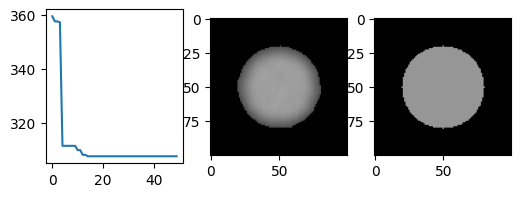

In [10]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="GA", 
        generations=50,
        population_size=50,
        verbose=True
)

i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

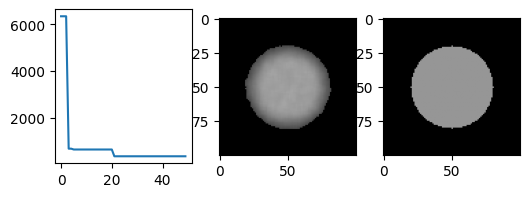

In [11]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="GS", 
        max_combinations=50,
        verbose=True
)

i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

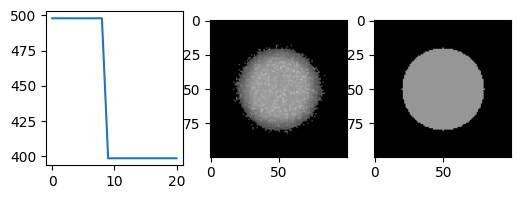

In [12]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="BO", 
        iterations=20,
        init_points=10,
        verbose=True
)

i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)